# Keras Tuner

In [1]:
import os
root_dir = '../../' if os.getcwd().split('/')[-1] != 'credit-now' else './'
os.chdir(root_dir)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers, utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_uniform
import keras_tuner as kt

import credit_data
import visualkeras
from joblib import dump, load

In [2]:
train_data, test_data, train_label, test_label = credit_data.load_data()

train_data = train_data.todense()
test_data = test_data.todense()
train_label = utils.to_categorical(train_label)
test_label = utils.to_categorical(test_label)

print(train_data.shape, test_data.shape, train_label.shape, test_label.shape)

(15906, 67) (6818, 67) (15906, 3) (6818, 3)


In [3]:
def build_hyper_model(hp):
    model = models.Sequential()

    hp_units = hp.Int('units_input', min_value=32, max_value=512, step=32)
    hp_activations = hp.Choice('activation_input', values=['relu', 'elu'])
    model.add(layers.Dense(input_dim=67, units=hp_units, activation=hp_activations, kernel_initializer=he_uniform()))
    model.add(layers.BatchNormalization())

    for layer_num in range(hp.Int('num_layers', min_value=1, max_value=5)):
        hp_units = hp.Int('units_' + str(layer_num), min_value=32, max_value=512, step=32)
        hp_activations = hp.Choice('activation_' + str(layer_num), values=['relu', 'elu'])
        model.add(layers.Dense(hp_units, activation=hp_activations, kernel_initializer=he_uniform()))
        hp_dropouts = hp.Float('dropout_' + str(layer_num), 0.0, 0.5, step=0.1)
        model.add(layers.Dropout(hp_dropouts))
        model.add(layers.BatchNormalization())
    model.add(layers.Dense(units=3, activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
    model.compile(optimizer=Adam(hp_learning_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    return model

In [4]:
tuner = kt.BayesianOptimization(build_hyper_model,
                                objective = 'val_accuracy',
                                max_trials = 100,
                                directory = 'keras_tuner',
                                project_name = 'bayes_depth5')

# tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project keras_tuner/bayes_depth5/oracle.json
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

INFO:tensorflow:Reloading Tuner from keras_tuner/bayes_depth5/tuner0.json


In [5]:
tuner.search(train_data, train_label, batch_size=100, epochs=10, validation_data=(test_data, test_label))

Trial 100 Complete [00h 01m 14s]
val_accuracy: 0.6887650489807129

Best val_accuracy So Far: 0.6921384930610657
Total elapsed time: 00h 22m 01s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary(num_trials=3)

In [7]:
top3_models = tuner.get_best_hyperparameters(num_trials=3)
# print(tuner.get_best_hyperparameters(num_trials=3)[0].space)
# print(tuner.get_best_hyperparameters(num_trials=3)[0].values)

for idx, model in enumerate(top3_models):
    print('Model performance rank :', idx)
    print(model.values)
    print()

best_hps = top3_models[0]

print("""
The hyperparameter search is complete. 
* Optimal # of layers : {}
* Optimal value of the learning-rate : {}""".format(best_hps.get('num_layers'), best_hps.get('learning_rate')))

for layer_num in range(best_hps.get('num_layers')):
    print('Layer {} - # of Perceptrons :'.format(layer_num), best_hps.get('units_' + str(layer_num)))
    print('Layer {} - Applied activation function :'.format(layer_num), best_hps.get('activation_' + str(layer_num)))

Model performance rank : 0
{'units_input': 512, 'activation_input': 'elu', 'num_layers': 1, 'units_0': 480, 'activation_0': 'elu', 'dropout_0': 0.5, 'learning_rate': 0.01, 'units_1': 512, 'activation_1': 'elu', 'dropout_1': 0.4, 'units_2': 512, 'activation_2': 'elu', 'dropout_2': 0.1, 'units_3': 32, 'activation_3': 'relu', 'dropout_3': 0.5, 'units_4': 320, 'activation_4': 'relu', 'dropout_4': 0.0}

Model performance rank : 1
{'units_input': 512, 'activation_input': 'elu', 'num_layers': 1, 'units_0': 512, 'activation_0': 'elu', 'dropout_0': 0.5, 'learning_rate': 0.01, 'units_1': 512, 'activation_1': 'elu', 'dropout_1': 0.5, 'units_2': 512, 'activation_2': 'elu', 'dropout_2': 0.2, 'units_3': 32, 'activation_3': 'relu', 'dropout_3': 0.5, 'units_4': 352, 'activation_4': 'relu', 'dropout_4': 0.0}

Model performance rank : 2
{'units_input': 512, 'activation_input': 'elu', 'num_layers': 5, 'units_0': 512, 'activation_0': 'elu', 'dropout_0': 0.5, 'learning_rate': 0.01, 'units_1': 512, 'activat

In [8]:
top_models = tuner.get_best_models(num_models=3)
top_model = top_models[0]
top_model.summary()
print()

results = top_model.evaluate(test_data, test_label)
print('Cross-entropy :', results[0])
print('Accuracy :', results[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               34816     
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 480)               246240    
                                                                 
 dropout (Dropout)           (None, 480)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 480)              1920      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 3)                 1

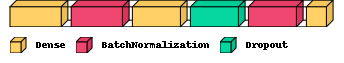

In [9]:
visualkeras.layered_view(top_model, legend=True)

In [ ]:
top_model.save('models/model_bayes5.h5')
dump(best_hps, 'models/params_bayes5.pkl')

In [19]:
best_hps = load('models/params_bayes5.pkl')

model = tuner.hypermodel.build(best_hps)
model.fit(train_data, train_label, batch_size=100, epochs=10, validation_data=(test_data, test_label))

results = model.evaluate(test_data, test_label)
print('Cross-entropy :', results[0])
print('Accuracy :', results[1])

Epoch 1/10
160/160 [==============================] - 6s 30ms/step - loss: 1.0274 - accuracy: 0.5939 - val_loss: 1.0029 - val_accuracy: 0.5581
Epoch 2/10
160/160 [==============================] - 4s 23ms/step - loss: 0.9212 - accuracy: 0.6323 - val_loss: 0.8697 - val_accuracy: 0.6662
Epoch 3/10
160/160 [==============================] - 4s 25ms/step - loss: 0.8768 - accuracy: 0.6590 - val_loss: 0.8448 - val_accuracy: 0.6740
Epoch 4/10
160/160 [==============================] - 4s 23ms/step - loss: 0.8499 - accuracy: 0.6745 - val_loss: 0.8202 - val_accuracy: 0.6867
Epoch 5/10
160/160 [==============================] - 4s 23ms/step - loss: 0.8327 - accuracy: 0.6818 - val_loss: 0.8312 - val_accuracy: 0.6776
Epoch 6/10
160/160 [==============================] - 3s 21ms/step - loss: 0.8271 - accuracy: 0.6814 - val_loss: 0.8237 - val_accuracy: 0.6836
Epoch 7/10
160/160 [==============================] - 4s 26ms/step - loss: 0.8213 - accuracy: 0.6854 - val_loss: 0.8226 - val_accuracy: 0.6880

## Max Depth 20

In [24]:
train_data, test_data, train_label, test_label = credit_data.load_data()

train_data = train_data.todense()
test_data = test_data.todense()
train_label = utils.to_categorical(train_label)
test_label = utils.to_categorical(test_label)

print(train_data.shape, test_data.shape, train_label.shape, test_label.shape)

(15906, 67) (6818, 67) (15906, 3) (6818, 3)


In [25]:
def build_hyper_model(hp):
    model = models.Sequential()

    hp_units = hp.Int('units_input', min_value=32, max_value=512, step=32)
    hp_activations = hp.Choice('activation_input', values=['relu', 'elu'])
    model.add(layers.Dense(input_dim=67, units=hp_units, activation=hp_activations, kernel_initializer=he_uniform()))
    model.add(layers.BatchNormalization())

    for layer_num in range(hp.Int('num_layers', min_value=5, max_value=20)):
        hp_units = hp.Int('units_' + str(layer_num), min_value=32, max_value=512, step=32)
        hp_activations = hp.Choice('activation_' + str(layer_num), values=['relu', 'elu'])
        model.add(layers.Dense(hp_units, activation=hp_activations, kernel_initializer=he_uniform()))
        hp_dropouts = hp.Float('dropout_' + str(layer_num), 0.0, 0.5, step=0.1)
        model.add(layers.Dropout(hp_dropouts))
        model.add(layers.BatchNormalization())
    model.add(layers.Dense(units=3, activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
    model.compile(optimizer=Adam(hp_learning_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    return model

In [26]:
tuner = kt.BayesianOptimization(build_hyper_model,
                                objective = 'val_accuracy',
                                max_trials = 100,
                                directory = 'keras_tuner',
                                project_name = 'bayes_depth20')

# tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project keras_tuner/model_hyper_deep/oracle.json


In [27]:
tuner.search(train_data, train_label, batch_size=100, epochs=10, validation_data=(test_data, test_label))

Trial 100 Complete [00h 01m 09s]
val_accuracy: 0.6902318000793457

Best val_accuracy So Far: 0.691845178604126
Total elapsed time: 05h 43m 50s
INFO:tensorflow:Oracle triggered exit


In [30]:
models = tuner.get_best_models(num_models=3)
top_model = models[0]
top_model.summary()
print()

results = top_model.evaluate(test_data, test_label)
print('Cross-entropy :', results[0])
print('Accuracy :', results[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               34816     
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 32)                1

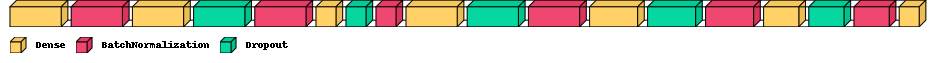

In [32]:
visualkeras.layered_view(top_model, legend=True)

In [33]:
top_model.save('models/model_hidden5.h5')

## Hyperband
RAM이 버티지 못해 29 trial 까지만 시도

In [ ]:
tuner = kt.Hyperband(build_hyper_model,
                    objective = 'val_accuracy',
                    max_epochs = 20,
                    directory = 'keras_tuner',
                    project_name = 'hyper_depth20')

In [ ]:
tuner.search(train_data, train_label, batch_size=100, epochs=10, validation_data=(test_data, test_label))

In [ ]:
models = tuner.get_best_models(num_models=3)
top_model = models[0]
top_model.summary()
print()

results = top_model.evaluate(test_data, test_label)
print('Cross-entropy :', results[0])
print('Accuracy :', results[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 352)               23936     
                                                                 
 batch_normalization (BatchN  (None, 352)              1408      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 416)               146848    
                                                                 
 dropout (Dropout)           (None, 416)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 416)              1664      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 384)               1

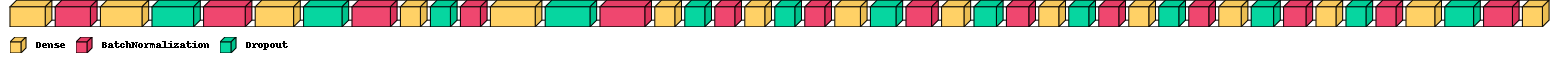

In [ ]:
visualkeras.layered_view(top_model, legend=True)

In [ ]:
top_model.save('models/model_hyperband.h5')